In [30]:
from feast import FeatureStore
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import accuracy_score,classification_report 
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from joblib import load

In [31]:
# Getting our FeatureStore
store = FeatureStore(repo_path=".")

In [32]:
# Retrieving the saved dataset and converting it to a DataFrame
training_df = store.get_saved_dataset(name="churn_dataset").to_df()
training_df

C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\feast\feature_store.py:1178: RuntimeWarning: Retrieving datasets is an experimental feature. This API is unstable and it could and most probably will be changed in the future. We do not guarantee that future changes will maintain backward compatibility.
  warnings.warn(


,Exited,EstimatedSalary,NumOfProducts,Gender,USER_ID,HasCrCard,event_timestamp,CreditScore,Balance,Age,Geography_Germany,Geography_Spain,Geography_France,IsActiveMember,Tenure
0,0,181605.85,2,1,7670,1,2023-01-01 00:00:00+00:00,631,0.00,38,False,True,False,0,7
1,1,115262.54,1,0,9729,0,2023-01-01 00:00:00+00:00,616,95984.21,43,True,False,False,1,7
2,0,142223.94,2,1,5378,1,2023-01-01 00:00:00+00:00,642,160541.00,72,False,False,True,1,1
3,0,10078.02,1,1,7693,1,2023-01-01 00:00:00+00:00,634,108891.70,74,True,False,False,0,5
4,1,7953.62,3,0,6496,1,2023-01-01 00:00:00+00:00,617,83348.89,39,True,False,False,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,54409.48,2,0,2871,0,2023-12-31 00:00:00+00:00,707,0.00,55,False,False,True,1,1
9996,0,99689.48,1,0,4667,1,2023-12-31 00:00:00+00:00,850,114491.82,39,True,False,False,0,5
9997,1,157527.60,2,0,2782,1,2023-12-31 00:00:00+00:00,732,94867.18,61,True,False,False,1,9
9998,0,86383.82,2,1,7909,0,2023-12-31 00:00:00+00:00,581,0.00,35,False,False,True,1,4


In [33]:
# Separating the features and labels
target = training_df['Exited']
features = training_df.drop(
    labels=['Exited', 'event_timestamp', "USER_ID"],
    axis=1)

In [34]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    stratify=target)

In [36]:
X_train = X_train[sorted(X_train.columns)]
X_test = X_test[sorted(X_train.columns)]

### Train - Random Forest

In [37]:
# Inizializza il modello
forest = RandomForestClassifier(n_estimators=100, random_state=42)
# Addestra il modello
forest.fit(X=X_train, y=y_train)

RandomForestClassifier(random_state=42)

In [38]:
# predict the mode
y_pred = forest.predict(X_test)
accuracy_score(y_test,y_pred)

0.8612

## Hyperparameter-tuning random forest

In [39]:
# Define the parameter grid
n_estimators = [20, 60, 100, 120]
max_features = [0.2, 0.6, 1.0]
max_depth = [2, 8, None]
max_samples = [0.5, 0.75, 1.0]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'max_samples': max_samples,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
print(param_grid)

{'n_estimators': [20, 60, 100, 120], 'max_features': [0.2, 0.6, 1.0], 'max_depth': [2, 8, None], 'max_samples': [0.5, 0.75, 1.0], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [40]:
rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                      param_distributions=param_grid, n_iter=100, cv=5, random_state=42)

In [41]:
rf_random_search.fit(X_train,y_train)

C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
300 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\claud\App

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, None],
                                        'max_features': [0.2, 0.6, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 60, 100, 120]},
                   random_state=42)

In [42]:
best_params = rf_random_search.best_params_
best_estimator = rf_random_search.best_estimator_

print("Best Parameters: ", best_params)
print("Best Estimator: ", best_estimator)

Best Parameters:  {'n_estimators': 120, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.5, 'max_features': 0.6, 'max_depth': None, 'bootstrap': True}
Best Estimator:  RandomForestClassifier(max_features=0.6, max_samples=0.5, min_samples_split=10,
                       n_estimators=120, random_state=42)


In [43]:
rf_random_search.best_score_

0.8652000000000001

In [44]:
# Make predictions and evaluate your model
y_pred_test = best_estimator.predict(X_test)
y_pred_train = best_estimator.predict(X_train)
accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.86


In [45]:
print("Test Set Performance:")
print(classification_report(y_test, y_pred_test))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1991
           1       0.77      0.45      0.56       509

    accuracy                           0.86      2500
   macro avg       0.82      0.71      0.74      2500
weighted avg       0.85      0.86      0.84      2500



In [46]:
print("Train Set Performance:")
print(classification_report(y_train, y_pred_train))

Train Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5972
           1       0.91      0.61      0.73      1528

    accuracy                           0.91      7500
   macro avg       0.91      0.80      0.84      7500
weighted avg       0.91      0.91      0.90      7500



In [47]:
# Save random forest model
dump(forest, r'models/random_forest_model.joblib')

['models/random_forest_model.joblib']

## Models comparison

In [48]:
# Load logistic regression model
logistic = load(r'models/logistic_regression.joblib')

In [49]:
y_pred_prob_1 = forest.predict_proba(X_test)[:, 1]
y_pred_prob_2 = logistic.predict_proba(X_test)[:, -1]

In [50]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_prob_1)
auc_1 = roc_auc_score(y_test, y_pred_prob_1)

In [51]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_prob_2)
auc_2 = roc_auc_score(y_test, y_pred_prob_2)

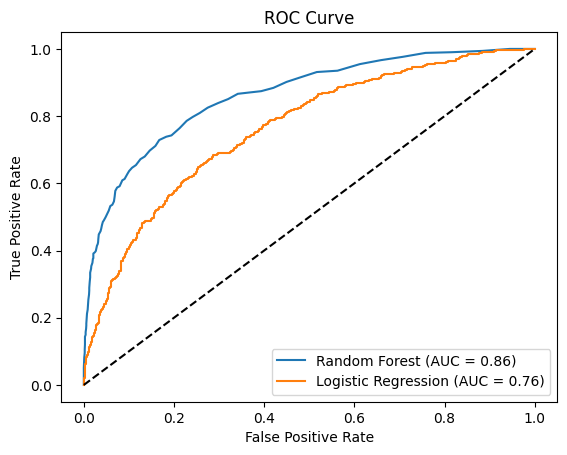

In [52]:
# Print ROC Curve
plt.plot(fpr_1, tpr_1, label=f'Random Forest (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Logistic Regression (AUC = {auc_2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()